In [ ]:
!pip install tfds_nightly

In [ ]:
!pip install tensorflow_addons

     |████████████████████████████████| 686kB 10.1MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd 
import pandas as pd 
import matplotlib.pyplot as plt 
import tensorflow_datasets as tfds 
import tensorflow as tf
import math   


In [ ]:
data_train, info = tfds.load("deep_weeds", with_info=True, split='train[:80%]')
data_valid  = tfds.load("deep_weeds",split='train[80%:90%]')
data_test = tfds.load("deep_weeds", split='train[90%:]')


Dataset deep_weeds downloaded and prepared to /root/tensorflow_datasets/deep_weeds/3.0.0. Subsequent calls will reuse this data.


In [ ]:
info.features

FeaturesDict({
    'image': Image(shape=(256, 256, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=9),
})

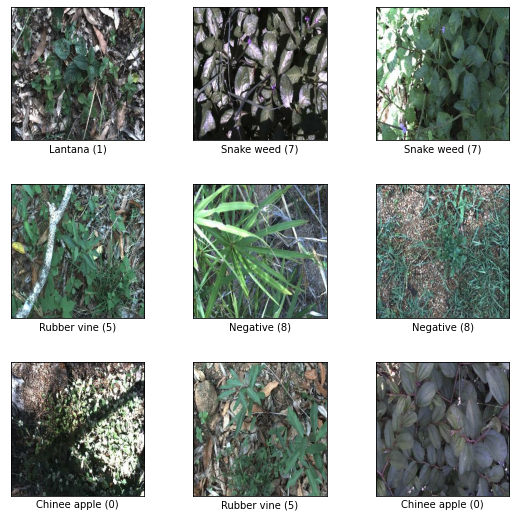

In [ ]:
fig = tfds.show_examples(data_train, info)

In [ ]:
def preprocess_weeds(dic):
  image = dic['image']
  preprocessed_image = tf.image.resize(image,[256,256])/255 # Scale to between 0 and 1
  label = dic['label']
  return preprocessed_image, label

# Use the batch method to prepare batches.
data_train_gen = data_train.map(preprocess_weeds).batch(32)
data_valid_gen = data_valid.map(preprocess_weeds).batch(32)
data_test_gen = data_test.map(preprocess_weeds).batch(32)

In [ ]:
import tensorflow_addons as tfa
def augment(image,label):
  image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_flip_up_down(image)
  image = tf.image.random_hue(image, max_delta=0.1)
  image = tf.image.random_contrast(image, lower=0.7, upper=1.3) # Adjust contrast
  delta = tf.random.uniform([], math.radians(-360),math.radians(360))
  image = tfa.image.rotate(image, delta)
  return image, label

In [ ]:
import tensorflow_addons as tfa
def augment(image,label):
  image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_flip_up_down(image)
  image = tf.image.random_hue(image, max_delta=0.1)
  image = tf.image.random_contrast(image, lower=0.7, upper=1.3) # Adjust contrast
  delta = tf.random.uniform([], math.radians(-360),math.radians(360))
  image = tfa.image.rotate(image, delta)
  return image, label

In [ ]:
data_train_gen = (data_train
                  .map(preprocess_weeds)
                  .map(augment,
                     num_parallel_calls = tf.data.experimental.AUTOTUNE)
                  .batch(32)
                  .prefetch(tf.data.experimental.AUTOTUNE))
data_valid_gen = (data_valid
                  .map(preprocess_weeds)
                  .batch(32)
                  .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/DeepWeedsModels/model.{epoch:02d}-{val_loss:.2f}.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
# Model weights are saved at the end of every epoch, if it's the best seen
# so far.

In [ ]:
from tensorflow.keras.layers import Input, Dense, Flatten
image_input = Input((256,256,3))
resnet = tf.keras.applications.ResNet50(include_top=False, weights="imagenet")
NUM_CLASSES=9
model = tf.keras.Sequential(
    [image_input,
     resnet,
     tf.keras.layers.Flatten(),
     Dense(NUM_CLASSES, activation="softmax")])
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics="accuracy")
model.fit(data_train_gen,epochs=100, batch_size=32, validation_data=data_valid_gen)

94773248/94765736 [==============================] - 1s 0us/step


Epoch 1/100
438/438 [==============================] - 115s 216ms/step - loss: 1.6929 - accuracy: 0.5559 - val_loss: 2.4995 - val_accuracy: 0.0691
Epoch 2/100
438/438 [==============================] - 94s 213ms/step - loss: 0.9792 - accuracy: 0.6577 - val_loss: 2.5349 - val_accuracy: 0.5094
Epoch 3/100
438/438 [==============================] - 94s 213ms/step - loss: 0.8199 - accuracy: 0.7156 - val_loss: 2.1686 - val_accuracy: 0.3815
Epoch 4/100
438/438 [==============================] - 94s 214ms/step - loss: 0.7441 - accuracy: 0.7426 - val_loss: 1.4221 - val_accuracy: 0.6117
Epoch 5/100
438/438 [==============================] - 94s 214ms/step - loss: 0.6747 - accuracy: 0.7669 - val_loss: 0.9734 - val_accuracy: 0.6773
Epoch 6/100
438/438 [==============================] - 94s 214ms/step - loss: 0.6229 - accuracy: 0.7845 - val_loss: 1.5196 - val_accuracy: 0.5774
Epoch 7/100
438/438 [==============================] - 94s 214ms/step - loss: 0.6042 - accuracy: 0.7917 - val_loss: 1.4021 

In [ ]:
model.evaluate(data_test_gen)

55/55 [==============================] - 20s 65ms/step - loss: 0.3173 - accuracy: 0.9235


[0.3173137605190277, 0.9234722852706909]

In [ ]:
model.save('deep_weed.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
!mv '/content/deep_weed.h5'  '/content/drive/MyDrive/DeepWeedsModels'